<a href="https://colab.research.google.com/github/PrathamSoneja/Hate-Speech-Recognition/blob/main/Hate_Speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import dependencies
##sklearn libs
!pip install contractions
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
##nlp libs
from nltk.tokenize import RegexpTokenizer
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
sp = spacy.load('en_core_web_sm')
from wordcloud import WordCloud
#essential libs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import regex as re
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option('display.max_columns', 999)
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_red = pd.read_csv('/content/drive/MyDrive/reddit_all.csv')
df_gab = pd.read_csv('/content/drive/MyDrive/gab_clean.csv')
df_red.drop('Unnamed: 0', axis=1, inplace=True)
df_gab.drop('Unnamed: 0', axis=1, inplace=True)
df_red['red'] = 1
df_gab['red'] = 0

In [ ]:
df = df_red.append(df_gab, ignore_index=True)
print(df.shape)
df.head(10)

(56034, 5)


,id,text,hate,response,red
0,e8q18lf,1. A subsection of retarded Hungarians? Ohh bo...,1,"[""I don't see a reason why it's okay to insult...",1
1,e8q9w5s,2. \tHiii. Just got off work. 444 is mainly th...,0,nil,1
2,e8qbobk,3. \t\twow i guess soyboys are the same in eve...,0,nil,1
3,e8qfn91,4. \t\t\tOwen Benjamin's soyboy song goes for ...,0,nil,1
4,e9c6naz,"1. > ""y'all hear sumn?"" by all means I live i...",0,nil,1
5,e9d03a5,2. \t[removed],0,nil,1
6,e9d8e4d,3. \t\tah a liberal has slipped in. you can te...,1,['Persons with disabilities is the accepted te...,1
7,e8q18lf,1. A subsection of retarded Hungarians? Ohh bo...,1,"[""I don't see a reason why it's okay to insult...",1
8,e8q9w5s,2. \tHiii. Just got off work. 444 is mainly th...,0,"[""I don't see a reason why it's okay to insult...",1
9,e8qbobk,3. \t\twow i guess soyboys are the same in eve...,0,"[""I don't see a reason why it's okay to insult...",1


In [ ]:
df.tail()

,id,text,hate,response,red
56029,38422734,3. \t\tfucking retard,1,['Using words that negatively describes someon...,0
56030,38710847,1. Twitter BANNED me and reported me to the FB...,0,"[""I don't think using words that are sexist in...",0
56031,38711592,2. \tI was routinely suspended for saying fuck...,1,"[""I don't think using words that are sexist in...",0
56032,38718122,3. \t\tThey got me for dropping the cunt bomb....,1,"[""I don't think using words that are sexist in...",0
56033,37951623,1. How absolutely unbelievably fascinating? A ...,1,"[""Using words that derogatorily reference a pa...",0


In [ ]:
df['hate'].value_counts()

0    35118
1    20916
Name: hate, dtype: int64

In [ ]:
df['text'][0]

'1. A subsection of retarded Hungarians? Ohh boy. brace for a livid Bulbasaur coming in here trying to hate a hole in some of her stupider countrymen.'

In [ ]:
stopwords_nltk =  set(stopwords.words('english'))

def cleaning_text(x):
  #preprocessing of text
  x = x.encode('ascii','ignore')
  x = x.decode()
  x = x.lower()
  x = contractions.fix(x)
  x = ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))])
  x =  re.sub('[^a-zA-Z0-9]', ' ', x)
  x = ' '.join(x.split())
  x = re.sub(r"((http|ftp|https):\/\/)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", x)
  x = re.sub('\\t+', '', x)
  x = re.sub('\d+\. ', '', x)
  pattern = "#[\w]*?"
  x = re.sub(pattern,'',x)
  return x


def tokenize_text(txt):
    #only take words or numbers in
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+', gaps=False)
    tokens = tokenizer.tokenize(txt)
    tokens = [token.lower() for token in tokens if not token.lower() in stopwords_nltk] #lowercase
    return tokens


def lemmatize(txt):
    text = sp(txt)
    #get all sentences
    sentence_lst = list(text.sents)
    lemma_words = []
    for sentence in sentence_lst:
        for word in sentence:
            lemma_words.append(word.lemma_)
    #return back as a string        
    return ' '.join(lemma_words)  


def token_lemma(txt):
    txt = ' '.join(txt)
    text = sp(txt)
    #get all sentences
    sentence_lst = list(text.sents)
    lemma_words = []
    for sentence in sentence_lst:
        for word in sentence:
            lemma_words.append(word.lemma_)
    #return back as a string        
    return ' '.join(lemma_words)   

In [ ]:
def preprocess(text):
  clean_text = cleaning_text(text)
  tokens = tokenize_text(text)
  lemma = lemmatize(text)
  tok_lemma = token_lemma(tokens)
  return [clean_text, tokens, lemma, tok_lemma]

In [ ]:
temp = pd.DataFrame(columns = ['clean_text','tokens','lemma','tok_lemma'])

for i in range(len(df['text'])):
  temp.loc[len(temp.index), ] = preprocess(df['text'][i])

temp

,clean_text,tokens,lemma,tok_lemma
0,1 subsection retarded hungarians ohh boy brace...,"[subsection, retarded, hungarians, ohh, boy, b...",1 . a subsection of retarded Hungarians ? ohh ...,subsection retarded hungarian ohh boy brace li...
1,2 hiii got work 444 mainly typa guys imagine w...,"[hiii, got, work, mainly, typa, guys, imagine,...",2 . \t Hiii . just get off work . 444 be mainl...,hiii get work mainly typa guy imagine write we...
2,3 wow guess soyboys every country,"[wow, guess, soyboys, every, country]",3 . \t\t wow I guess soyboy be the same in eve...,wow guess soyboy every country
3,4 owen benjamin s soyboy song goes every count...,"[owen, benjamin, soyboy, song, goes, every, co...",4 . \t\t\t Owen Benjamin 's soyboy song go for...,owen benjamin soyboy song go every country ama...
4,1 you hear sumn means live small town right fo...,"[hear, sumn, means, live, small, town, rn, wor...","1 . > "" you all hear sumn ? "" by all mean I ...",hear sumn mean live small town rn work k peopl...
...,...,...,...,...
56029,3 fucking retard,"[fucking, retard]",3 . \t\t fuck retard,fuck retard
56030,1 twitter banned reported fbi stating obvious ...,"[twitter, banned, reported, fbi, stating, obvi...",1 . twitter ban I and report I to the FBI for ...,twitter ban report fbi state obvious order thr...
56031,2 routinely suspended saying fuck banned calli...,"[routinely, suspended, saying, fuck, banned, c...","2 . \t I be routinely suspend for say fuck , a...",routinely suspend say fuck ban call prominent ...
56032,3 got dropping cunt bomb lot,"[got, dropping, cunt, bomb, lot]",3 . \t\t they get I for drop the cunt bomb ......,get drop cunt bomb lot


In [ ]:
dataset = pd.concat([df[['text','hate']], temp], axis = 1)
dataset.head()

,text,hate,clean_text,tokens,lemma,tok_lemma
0,1. A subsection of retarded Hungarians? Ohh bo...,1,1 subsection retarded hungarians ohh boy brace...,"[subsection, retarded, hungarians, ohh, boy, b...",1 . a subsection of retarded Hungarians ? ohh ...,subsection retarded hungarian ohh boy brace li...
1,2. \tHiii. Just got off work. 444 is mainly th...,0,2 hiii got work 444 mainly typa guys imagine w...,"[hiii, got, work, mainly, typa, guys, imagine,...",2 . \t Hiii . just get off work . 444 be mainl...,hiii get work mainly typa guy imagine write we...
2,3. \t\twow i guess soyboys are the same in eve...,0,3 wow guess soyboys every country,"[wow, guess, soyboys, every, country]",3 . \t\t wow I guess soyboy be the same in eve...,wow guess soyboy every country
3,4. \t\t\tOwen Benjamin's soyboy song goes for ...,0,4 owen benjamin s soyboy song goes every count...,"[owen, benjamin, soyboy, song, goes, every, co...",4 . \t\t\t Owen Benjamin 's soyboy song go for...,owen benjamin soyboy song go every country ama...
4,"1. > ""y'all hear sumn?"" by all means I live i...",0,1 you hear sumn means live small town right fo...,"[hear, sumn, means, live, small, town, rn, wor...","1 . > "" you all hear sumn ? "" by all mean I ...",hear sumn mean live small town rn work k peopl...


In [ ]:
dataset.drop_duplicates(subset=['lemma'], inplace=True)

In [ ]:
dataset.head()

,text,hate,clean_text,tokens,lemma,tok_lemma
0,1. A subsection of retarded Hungarians? Ohh bo...,1,1 subsection retarded hungarians ohh boy brace...,"[subsection, retarded, hungarians, ohh, boy, b...",1 . a subsection of retarded Hungarians ? ohh ...,subsection retarded hungarian ohh boy brace li...
1,2. \tHiii. Just got off work. 444 is mainly th...,0,2 hiii got work 444 mainly typa guys imagine w...,"[hiii, got, work, mainly, typa, guys, imagine,...",2 . \t Hiii . just get off work . 444 be mainl...,hiii get work mainly typa guy imagine write we...
2,3. \t\twow i guess soyboys are the same in eve...,0,3 wow guess soyboys every country,"[wow, guess, soyboys, every, country]",3 . \t\t wow I guess soyboy be the same in eve...,wow guess soyboy every country
3,4. \t\t\tOwen Benjamin's soyboy song goes for ...,0,4 owen benjamin s soyboy song goes every count...,"[owen, benjamin, soyboy, song, goes, every, co...",4 . \t\t\t Owen Benjamin 's soyboy song go for...,owen benjamin soyboy song go every country ama...
4,"1. > ""y'all hear sumn?"" by all means I live i...",0,1 you hear sumn means live small town right fo...,"[hear, sumn, means, live, small, town, rn, wor...","1 . > "" you all hear sumn ? "" by all mean I ...",hear sumn mean live small town rn work k peopl...


In [ ]:
data = dataset[['tok_lemma','hate']]
data_pos = dataset[dataset['hate'] == 0]
data_neg = dataset[dataset['hate'] == 1]

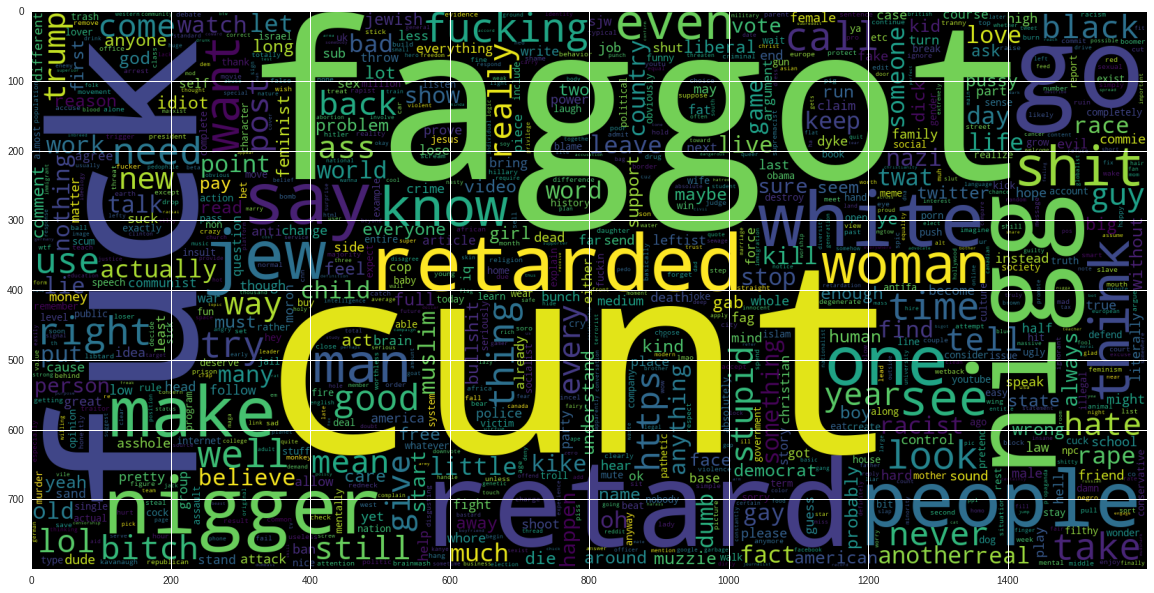

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg['tok_lemma']))
plt.imshow(wc)

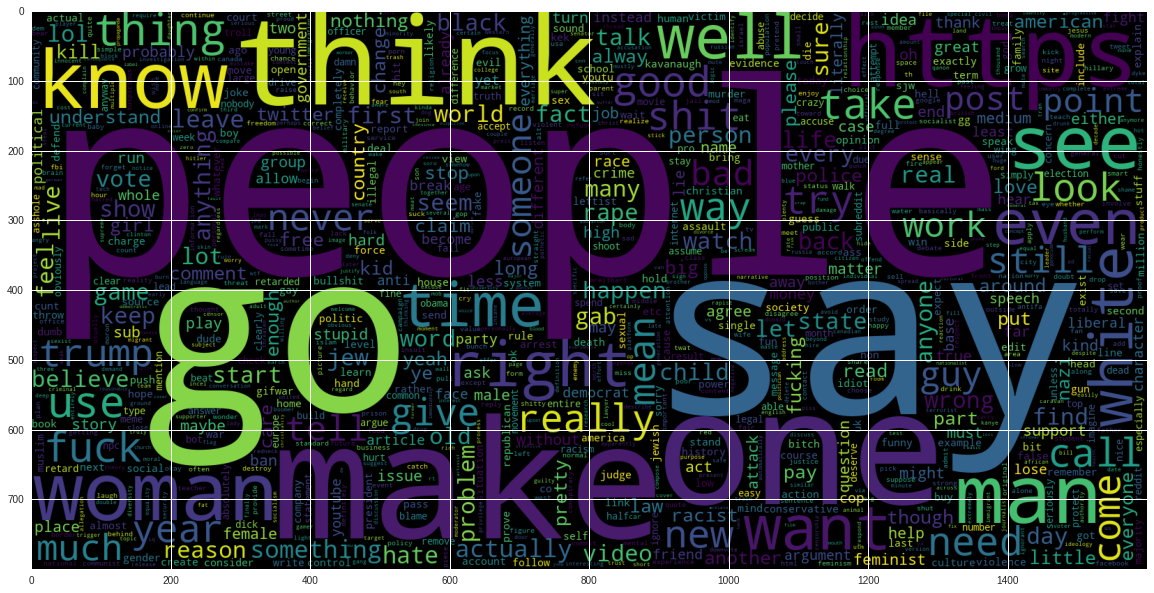

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos['tok_lemma']))
plt.imshow(wc)

In [ ]:
X = data['tok_lemma']
y = data['hate']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=28, test_size = 0.33)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000, min_df = 3)
logreg = LogisticRegression(C = 2, n_jobs = -1, max_iter = 1000)

X_train_tfidf = vectoriser.fit_transform(X_train)
X_test_tfidf = vectoriser.transform(X_test)

logreg.fit(X_train_tfidf, y_train)
pred_lr = logreg.predict(X_test_tfidf)

accuracy = np.round(accuracy_score(y_test, pred_lr), 4)
report = classification_report(y_test, pred_lr, target_names=['Predict 0', 'Predict 1'], output_dict=True)
class_table = pd.DataFrame(report).transpose()
print(f'classification report:\n')
display(class_table)
print('\n')
tn, fp, fn, tp = confusion_matrix(y_test, pred_lr).ravel()
print(f"{str(LogisticRegression()).split('(')[0]} Confusion Matrix:")
print(f"True Positives: {tp}\tTrue Negatives: {tn}")
print(f"False Positives: {fp}\tFalse Negatives: {fn}")
print('\n')
print(f'accuracy: {accuracy*100}%')


classification report:



,precision,recall,f1-score,support
Predict 0,0.873102,0.950595,0.910202,10343.000000
Predict 1,0.909091,0.781465,0.840461,6539.000000
accuracy,0.885085,0.885085,0.885085,0.885085
macro avg,0.891096,0.866030,0.875331,16882.000000
weighted avg,0.887042,0.885085,0.883189,16882.000000




LogisticRegression Confusion Matrix:
True Positives: 5110	True Negatives: 9832
False Positives: 511	False Negatives: 1429


accuracy: 88.51%


In [ ]:
#sample of hate speech prediction

def predict(text):
  pred = logreg.predict(vectoriser.transform([text]))
  if pred[0] == 1:
    return 'The text is hateful.'
  else:
    return 'The text is not hateful.'

print(f'text: {X_test[0]} \n\nprediction: {predict(X_test[0])} \n\ntrue value: {y_test[0]}\n')

print(f'text: {X_test[1]} \n\nprediction: {predict(X_test[1])} \n\ntrue value: {y_test[1]}\n\n')

text: subsection retarded hungarian ohh boy brace livid bulbasaur come try hate hole stupider countryman 

prediction: The text is hateful. 

true value: 1

text: hiii get work mainly typa guy imagine write we stupid site basically try fit western european us big city hipster rich kid budapest feel brave journalistic hero 

prediction: The text is not hateful. 

true value: 0




In [ ]:
import pickle

pickle.dump(logreg, open('LRmodel.sav', 'wb'))
pickle.dump(vectoriser, open('TFIDFVectoriser.sav', 'wb'))

In [ ]:
dataset.text

,text,hate,clean_text,tokens,lemma,tok_lemma
0,1. A subsection of retarded Hungarians? Ohh bo...,1,1 subsection retarded hungarians ohh boy brace...,"[subsection, retarded, hungarians, ohh, boy, b...",1 . a subsection of retarded Hungarians ? ohh ...,subsection retarded hungarian ohh boy brace li...
1,2. \tHiii. Just got off work. 444 is mainly th...,0,2 hiii got work 444 mainly typa guys imagine w...,"[hiii, got, work, mainly, typa, guys, imagine,...",2 . \t Hiii . just get off work . 444 be mainl...,hiii get work mainly typa guy imagine write we...
2,3. \t\twow i guess soyboys are the same in eve...,0,3 wow guess soyboys every country,"[wow, guess, soyboys, every, country]",3 . \t\t wow I guess soyboy be the same in eve...,wow guess soyboy every country
3,4. \t\t\tOwen Benjamin's soyboy song goes for ...,0,4 owen benjamin s soyboy song goes every count...,"[owen, benjamin, soyboy, song, goes, every, co...",4 . \t\t\t Owen Benjamin 's soyboy song go for...,owen benjamin soyboy song go every country ama...
4,"1. > ""y'all hear sumn?"" by all means I live i...",0,1 you hear sumn means live small town right fo...,"[hear, sumn, means, live, small, town, rn, wor...","1 . > "" you all hear sumn ? "" by all mean I ...",hear sumn mean live small town rn work k peopl...


In [223]:
logreg.predict(vectoriser.transform(['you are a fucking piece of shit']))

array([1])